In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tableone import TableOne
from statsmodels.api import OLS
from statsmodels.stats import proportion
from patsy import dmatrices
from scipy.stats import ttest_1samp
wd = "/Users/timvigers/Dropbox/Work/Viral Shah/ADA 2022/"

## Data
- Participants with HbA1c >= 6.5 were excluded from Kaan's CGM dataset. The remaining participants were combined with publicly available data on non-diabetics from the JAEB (https://public.jaeb.org/datasets/diabetes).
- For each participant, mean blood glucose was calculated from CGM data, and GMI calculated according to the standard equation (3.31 + 0.02392 * MBG). 
- GMI was compared to lab HbA1c, and a new GMI regression equation was estimated for this population. 

In [19]:
# Import Kaan's data
df = pd.read_csv(wd + "Data_Clean/analysis_data.csv",usecols=["14 Day Mean","HbA1c"])
# Only HbA1c < 6.5
df = df[df["HbA1c"] < 6.5]
df.columns = ["HbA1c","MBG"]
df = df[["MBG","HbA1c"]]
df["MBG"] = [round(m,2) for m in df["MBG"]]
# Add JAEB data
jaeb_cgm = pd.read_csv(wd + "Data_Raw/CGMND/NonDiabDeviceCGM.csv")
jaeb_cgm = jaeb_cgm[jaeb_cgm["RecordType"] == "CGM"]
# Split by ID
dataframes = []
for _, d in jaeb_cgm.groupby(["PtID"]):
    dataframes.append(d)
# Calculate mean glucose for each participant
mean_bgs = {"PtID":[],"MBG":[]}
for d in dataframes:
    mean_bgs["PtID"].append(d["PtID"].iloc[0])
    mean_bgs["MBG"].append(round(d["Value"].mean(),2))
mean_bgs = pd.DataFrame(mean_bgs)
# Exclude patients (per Stephanie DuBose)
exclude = pd.read_csv(wd+"Data_Raw/List of Excluded Pts.csv")
idx = ~mean_bgs['PtID'].isin(exclude['PtID'])
mean_bgs = mean_bgs[idx]
# Add HbA1c
jaeb_a1c = pd.read_csv(wd + "Data_Raw/CGMND/NonDiabScreening.csv",usecols=["PtID","HbA1c"])
jaeb_a1c["PtID"] = [str(p) for p in jaeb_a1c["PtID"]]
mean_bgs["PtID"] = [str(p) for p in mean_bgs["PtID"]]
mean_bgs = mean_bgs.merge(jaeb_a1c,on = "PtID")
mean_bgs = mean_bgs[["MBG","HbA1c"]]
mean_bgs = mean_bgs[mean_bgs["HbA1c"] < 6.5]
# Combine
df = pd.concat([df,mean_bgs])
# Calculate GMI
df["GMI"] = [3.31 + 0.02392*m for m in df["MBG"]]
df["Diff"] = df["HbA1c"] - df["GMI"]
df.reset_index(inplace=True,drop=True)
# Write
df.to_csv(wd + 'Data_Clean/combined_data.csv',index=False)
# Split by HbA1c < 5.7 and 5.7 - 6.5
nondiab = df[df['HbA1c'] < 5.7]
prediab = df[(df['HbA1c'] >= 5.7) & (df['HbA1c'] < 6.5)]
# Reindex
nondiab.reset_index(inplace=True,drop=True)
prediab.reset_index(inplace=True,drop=True)

# HbA1c < 5.7

## Mean Glucose and HbA1c
Red line indicates GMI regression line.

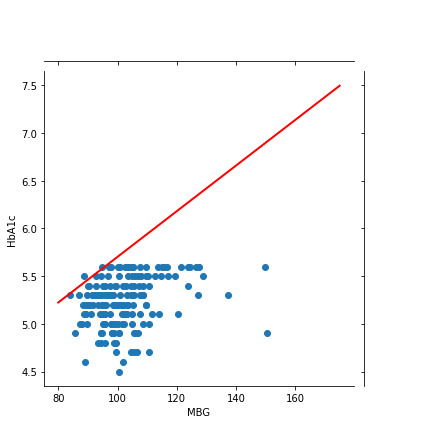

In [20]:
grid = sns.JointGrid(x=nondiab["MBG"],y=nondiab["HbA1c"])
grid.plot_joint(plt.scatter)
plt.plot([80,175],[5.2236,7.496], linewidth=2, color = "r");

## Differences between HbA1c and GMI

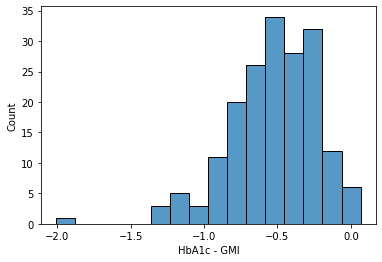

In [21]:
sns.histplot(data=nondiab, x="Diff")
plt.xlabel("HbA1c - GMI");

In [22]:
plt.savefig(wd + "Reports/figure_under_5.7.png")

<Figure size 432x288 with 0 Axes>

In [5]:
t = ttest_1samp(nondiab["Diff"],popmean = 0)
t.pvalue
nondiab["Diff"].mean()

-0.5204280839779007

The differences between HbA1c and GMI were largely negative, suggesting that the standard GMI equation overestimates HbA1c in this cohort. On average, GMI was 0.52% higher, and this was significantly different from 0 (p < 0.0001).

## Regression Results

In [6]:
outcome,predictors = dmatrices("HbA1c ~ MBG",data = nondiab)
reg = OLS(outcome,predictors).fit()

In [7]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  HbA1c   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     17.07
Date:                Tue, 04 Jan 2022   Prob (F-statistic):           5.51e-05
Time:                        10:43:39   Log-Likelihood:               0.031050
No. Observations:                 181   AIC:                             3.938
Df Residuals:                     179   BIC:                             10.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.5258      0.172     26.272      0.000       4.186       4.866
MBG            0.0069      0.002      4.132      0.000       0.004       0.010
==============================================================================
Omnibus:                       11.445   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.285
Skew:                          -0.638   Prob(JB):                      0.00215
Kurtosis:                       3.016   Cond. No.                         979.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on this dataset, the regression equation for GMI would be:

GMI = 3.4551 + 0.0180 * MBG

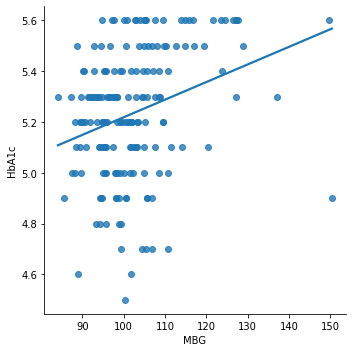

In [8]:
sns.lmplot(x="MBG",y="HbA1c",data=nondiab,ci=None);

# HbA1c 5.7 - 6.5
## Mean Glucose and HbA1c
Red line indicates GMI regression line.

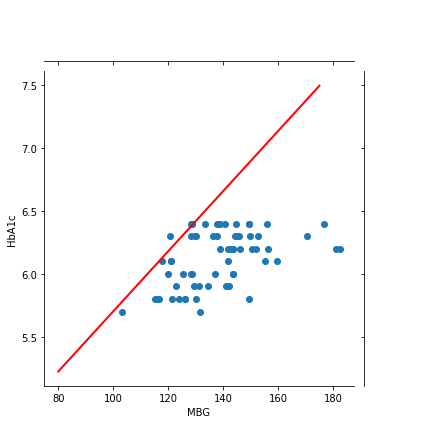

In [9]:
grid = sns.JointGrid(x=prediab["MBG"],y=prediab["HbA1c"])
grid.plot_joint(plt.scatter)
plt.plot([80,175],[5.2236,7.496], linewidth=2, color = "r");

## Differences between HbA1c and GMI

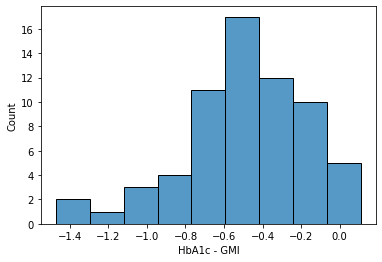

In [10]:
sns.histplot(data=prediab, x="Diff")
plt.xlabel("HbA1c - GMI");

In [ ]:
plt.savefig(wd + "figure.png")

In [16]:
t = ttest_1samp(prediab["Diff"],popmean = 0)
t.pvalue
prediab["Diff"].mean()

-0.49032615384615386

The differences between HbA1c and GMI were largely negative, suggesting that the standard GMI equation overestimates HbA1c in this cohort. On average, GMI was 0.5% higher, and this was significantly different from 0 (p < 0.0001).

## Regression Results

In [12]:
outcome,predictors = dmatrices("HbA1c ~ MBG",data = prediab)
reg = OLS(outcome,predictors).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  HbA1c   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     16.77
Date:                Tue, 04 Jan 2022   Prob (F-statistic):           0.000122
Time:                        10:43:39   Log-Likelihood:                 14.701
No. Observations:                  65   AIC:                            -25.40
Df Residuals:                      63   BIC:                            -21.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2418      0.217     24.121      0.000       4.808       5.676
MBG            0.0064      0.002      4.095      0.000       0.003       0.010
==============================================================================
Omnibus:                        9.484   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                2.990
Skew:                           0.021   Prob(JB):                        0.224
Kurtosis:                       1.950   Cond. No.                     1.24e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

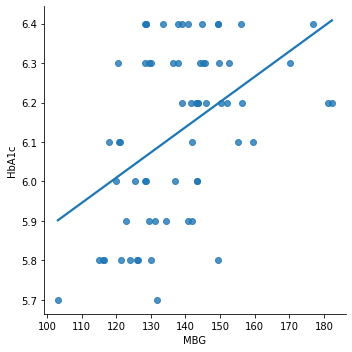

In [13]:
sns.lmplot(x="MBG",y="HbA1c",data=prediab,ci=None);